## Australian magnetic intensity

Here I am going to show you how to make a map of magnetic intensity using 2 different datasets and various masks. The data for the Australian continent came from tiles from the AuScope data portal which I downloaded one day and stitched together with an open-source geotiff tool.

We'll use that dataset in conjunction with the global magnetic dataset I already gave you.



In [30]:
%pylab inline
import cartopy
import cartopy.crs as ccrs
import imageio, PIL
import matplotlib.pyplot as plt


Populating the interactive namespace from numpy and matplotlib


In [34]:
def download_from_cloudstor(cs_path, local_file, force=False):
    from cloudstor import cloudstor
    import os

    teaching_data = cloudstor(url="L93TxcmtLQzcfbk", password='')
    
    if os.path.isfile(local_file) and not force:
        print("File exists ({}) skipping".format(local_file))
    else:
        teaching_data.download(cs_path, local_file)

    return

In [37]:
# Global Data
    
try:
    download_from_cloudstor("EMAG2_image_V2_Small.tif", "EMAG2_image_V2_Small.tif", force=False)
    globalmag_img = imageio.imread("EMAG2_image_V2_Small.tif")
except:
    download_from_cloudstor("EMAG2_image_V2_Small.tif", "AusMagAll.tif", force=True)
    globalmag_img = imageio.imread("EMAG2_image_V2_Small.tif")

    
# High resolution total magnetic intensity image map for Australia's land mass (with background masked)

try:
    download_from_cloudstor("AusMagAll.tiff", "AusMagAll.tiff", force=False)
    ausmag_img = imageio.imread("AusMagAll.tiff")
except:
    download_from_cloudstor("AusMagAll.tiff", "AusMagAll.tiff", force=True)
    ausmag_img = imageio.imread("AusMagAll.tiff")

    
    


Cloudstore connection established
File exists (EMAG2_image_V2_Small.tif) skipping
Cloudstore connection established
File exists (AusMagAll.tiff) skipping


In [38]:

## Note that we can use the metadata to find the span of the data in the image
## 
austmag_extent = [108.0, 160.9989658738366, -46.001727115716754, -5.0]


# Mask out (alpha=0.0) areas with no information (blank = white)

red, green, blue, alpha = austmag_img.T  # Temporarily unpack the bands for readability
blank_areas = (red == 255) & (blue == 255) & (green == 255)
austmag_img[...,3][blank_areas.T] = 0


In [39]:
## This is how to read the image tags ... (See TiePoint ... PixelScale etc )

# from PIL import Image
# from PIL.TiffTags import TAGS
# with Image.open('AusMagAll.tiff') as img:
#     for key in img.tag: 
#         print(key, TAGS[key], img.tag[key])

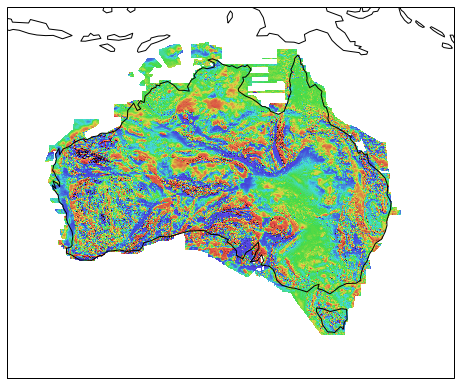

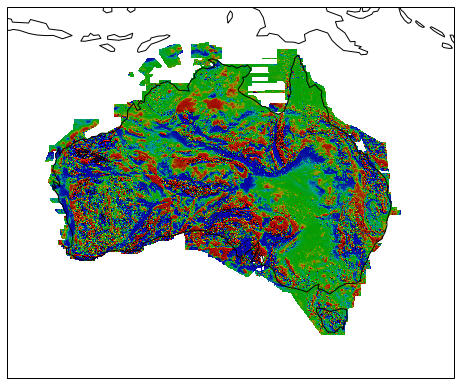

In [40]:


# And here it is ... 

base_projection   = ccrs.PlateCarree() 

fig = plt.figure(figsize=(8, 10), facecolor="none")
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(austmag_extent)
plt.imshow(austmag_img, zorder=0, transform=ccrs.PlateCarree(), extent=austmag_extent)
ax.coastlines(color="Black", zorder=1)  
plt.show()


# This one is a bit flat, but we can boost the contrast 
# (either channel by channel or all with the same N)

N = 3.0
austmag_img[...,0] = 255 * (austmag_img[...,0] / 255.0)**N
austmag_img[...,1] = 255 * (austmag_img[...,1] / 255.0)**N 
austmag_img[...,2] = 255 * (austmag_img[...,2] / 255.0)**N 


fig = plt.figure(figsize=(8, 10), facecolor="none")
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(austmag_extent)
plt.imshow(austmag_img, zorder=0, transform=ccrs.PlateCarree(), extent=austmag_extent)
ax.coastlines(color="Black", zorder=1)  
plt.show()

# Try changing N !

## Features

We already used the ``coastlines`` command, but this is actually a special case of how we add *features* to our maps. Features can be things like rivers or roads, towns, political boundaries. There is a web service called [Natural Earth](http://www.naturalearthdata.com/features/) where you can download this information. Cartopy provides functions to grab this information without having to construct the URL by hand. The only problem is that you still need to know what stuff you can grab. Here are some examples though, and you can see how to choose a resolution for the information which is useful for zoomed in or zoomed out maps.

In [41]:
# "Features" such as land, ocean, coastlines (50m =  the 1:50 million scale)

import cartopy.feature as cfeature

land = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                           edgecolor="green",
                           facecolor="white")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                           edgecolor="green",
                           facecolor="blue")

coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                           edgecolor=(1.0,0.8,0.0),
                           facecolor="none")

# Add these to the plot object as
# ax.add_feature(coastline, linewidth=4, edgecolor=(1,0,1), zorder=1)
# and so forth. zorder is used to force the layering as required.

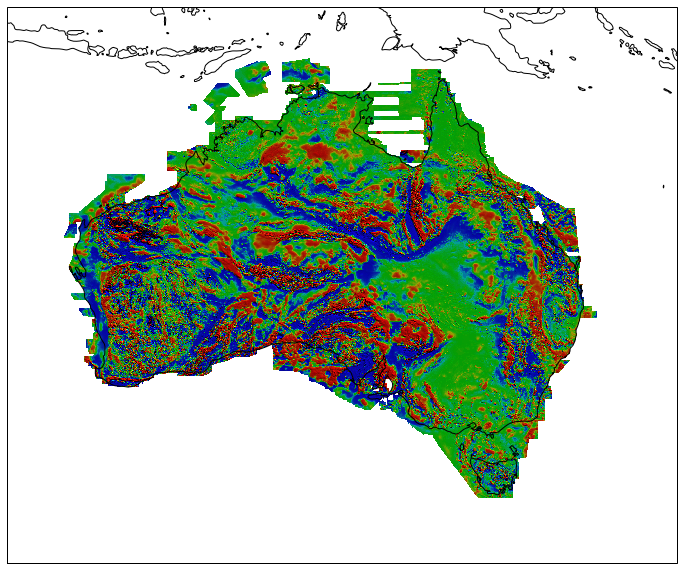

In [42]:

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax  = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(austmag_extent)
plt.imshow(austmag_img, zorder=0, transform=ccrs.PlateCarree(), extent=austmag_extent)
ax.add_feature(coastline, linewidth=1, edgecolor="Black", zorder=1)
plt.show()

Now let us add the global (lower resolution) dataset in the background, mask things up and add coastlines

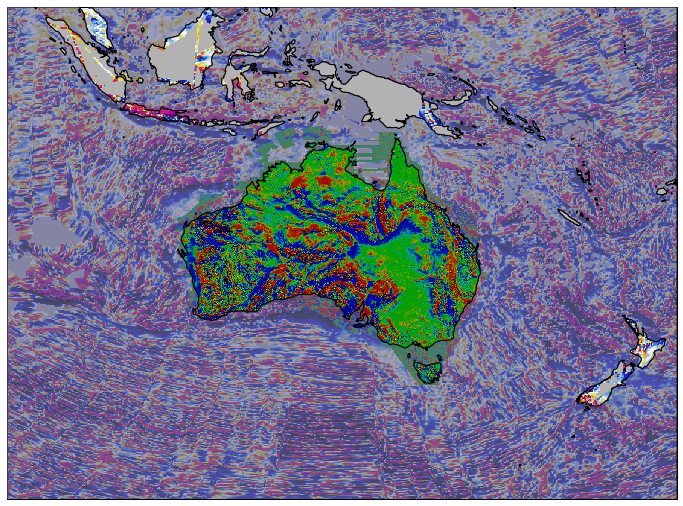

In [43]:
projection = ccrs.PlateCarree()
base_projection = ccrs.PlateCarree()
global_extent     = [-180.0, 180.0, -90.0, 90.0]

fig = plt.figure(figsize=(12, 12), facecolor="none")
ax = plt.axes(projection=projection)
ax.set_extent([90, 180, -50, 5])

ax.imshow(globalmag_img, origin='upper', transform=base_projection, extent=global_extent, zorder=0)
# ax.add_feature(land, facecolor="red", edgecolor="red", alpha=0.1, linewidth=0.5, zorder=1)
ax.add_feature(ocean, facecolor=(0.4,0.4,0.6), edgecolor=(0.0,0.0,0.0), linewidth=1, alpha=0.6, zorder=3)
ax.imshow(austmag_img, origin='upper', transform=base_projection, extent=austmag_extent, zorder=2)
ax.add_feature(coastline, edgecolor="black", linewidth=1, zorder=3)

plt.show()
